##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

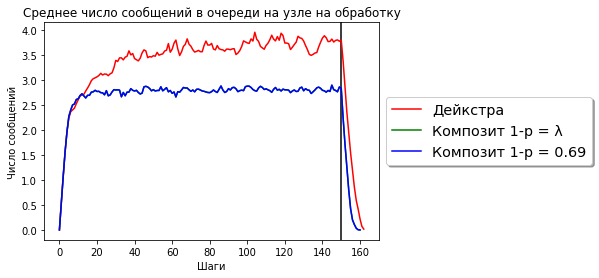

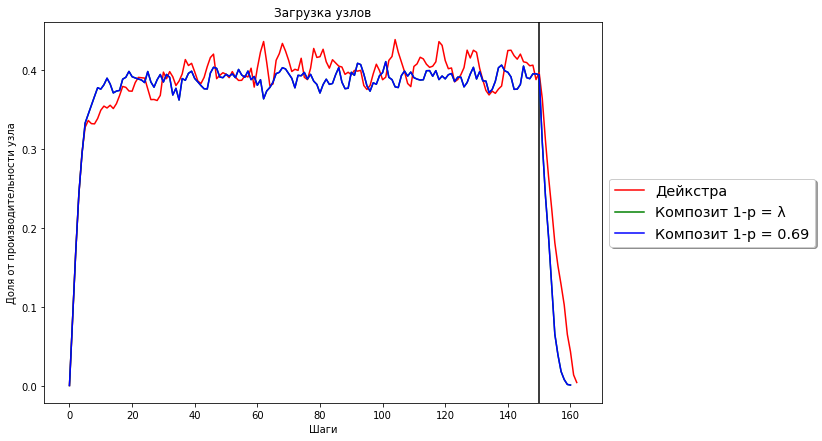

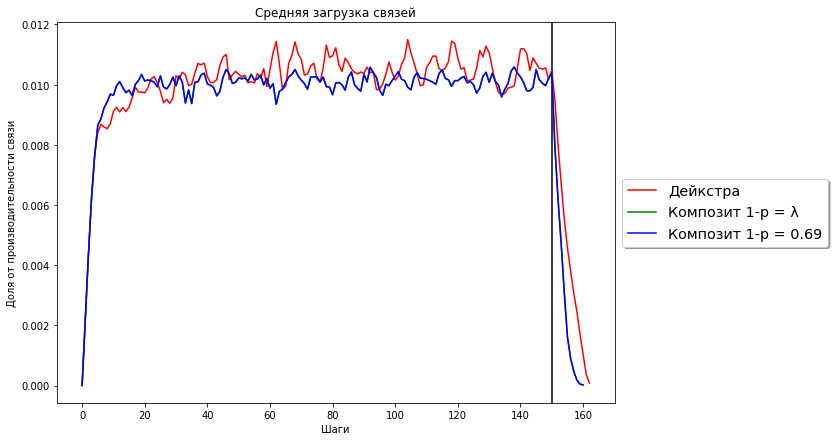

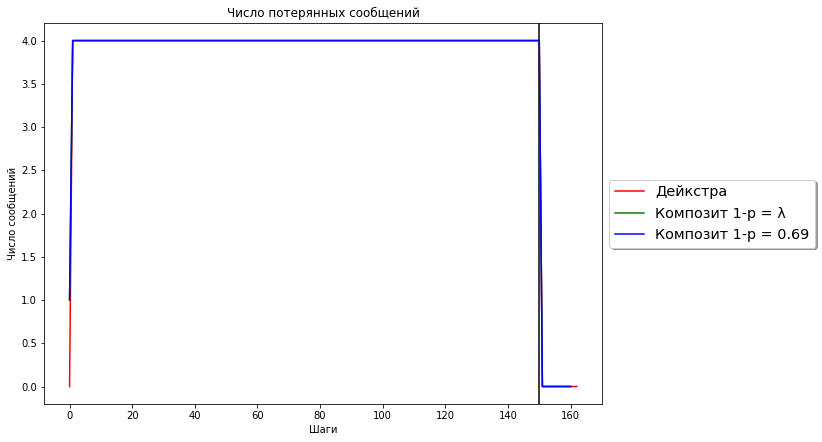

Доставлено 14401 Потеряно 3.9997% -Дейкстра
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = λ
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = 0.69


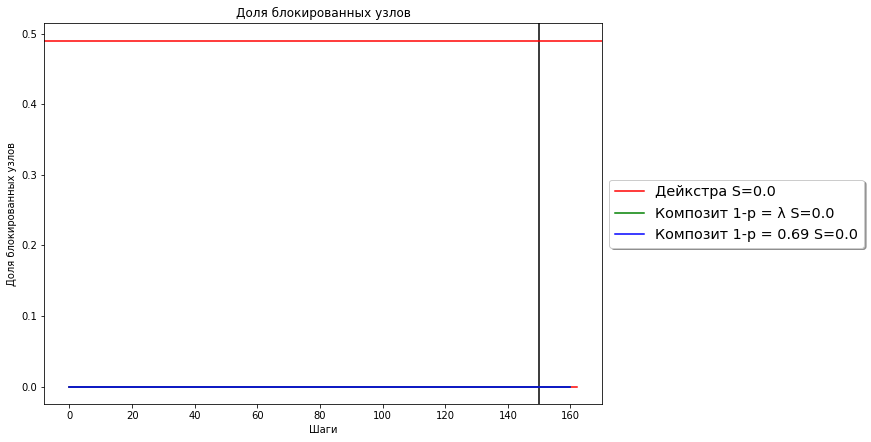

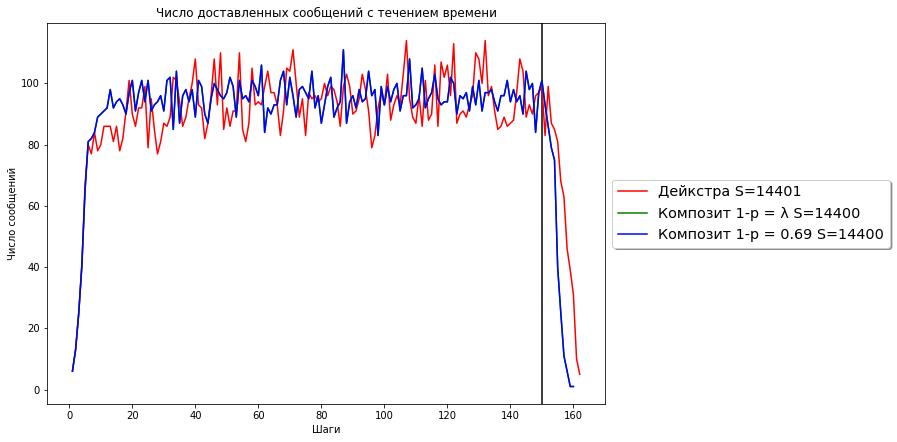

In [2]:
log_tags = [
 {"tag":  "3df4ab63-98e7-4b81-995a-d5fef10cf03e", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "f67304d6-a499-442e-b728-892945ef0d28", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "5a9f4cc5-b358-40b8-b2ba-bf8a8f387960", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

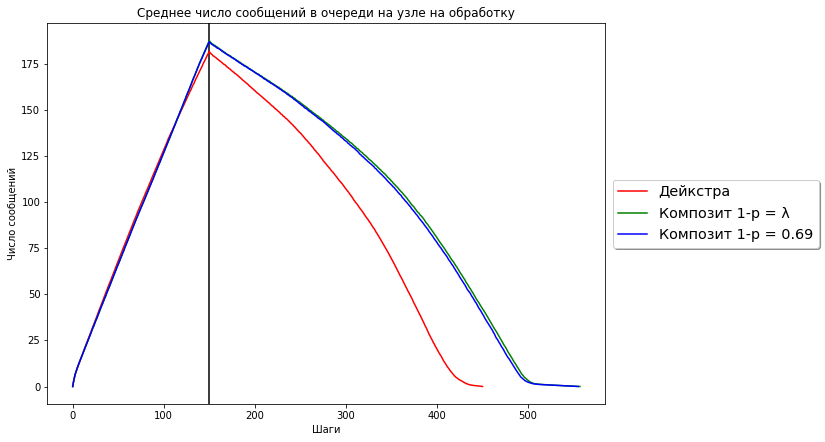

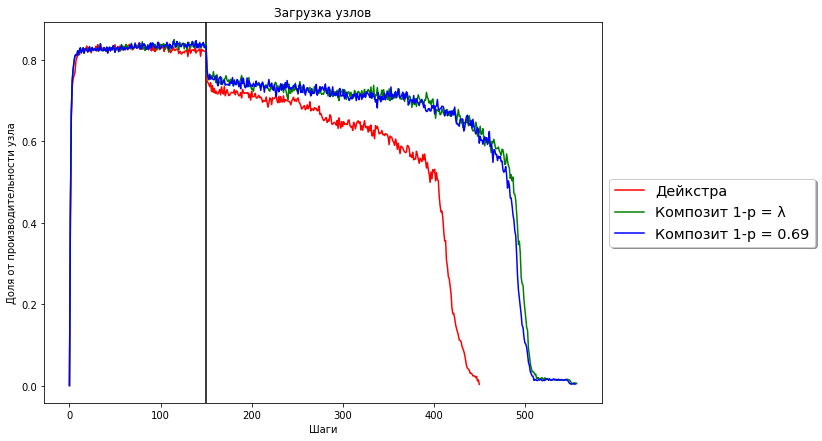

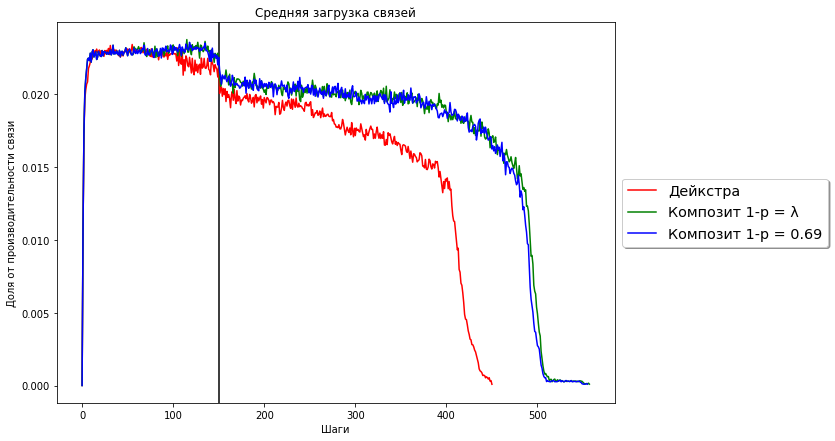

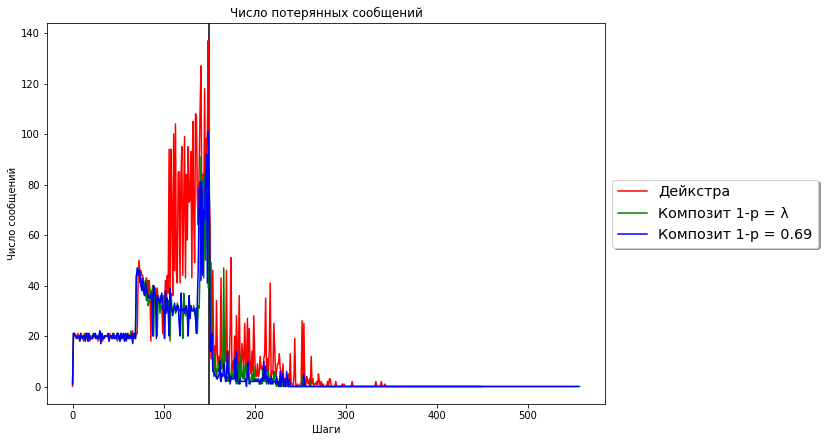

Доставлено 67497 Потеряно 10.0052% -Дейкстра
Доставлено 70132 Потеряно 6.4919% -Композит 1-p = λ
Доставлено 70143 Потеряно 6.4772% -Композит 1-p = 0.69


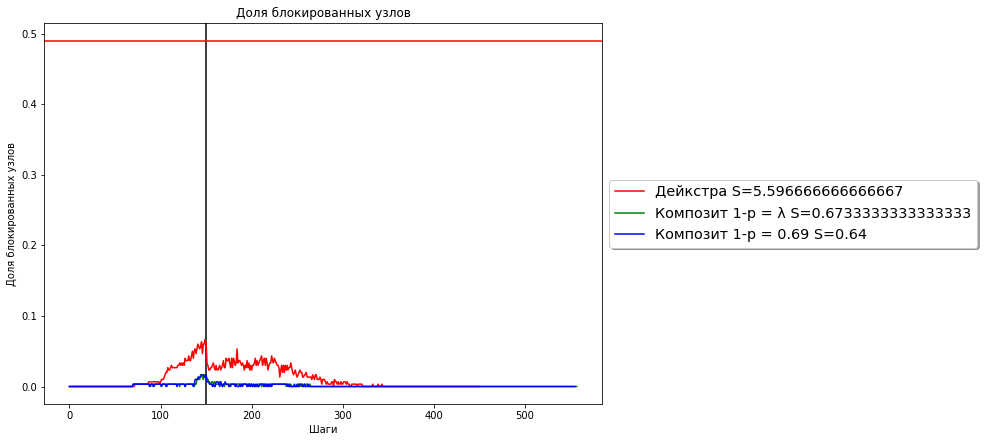

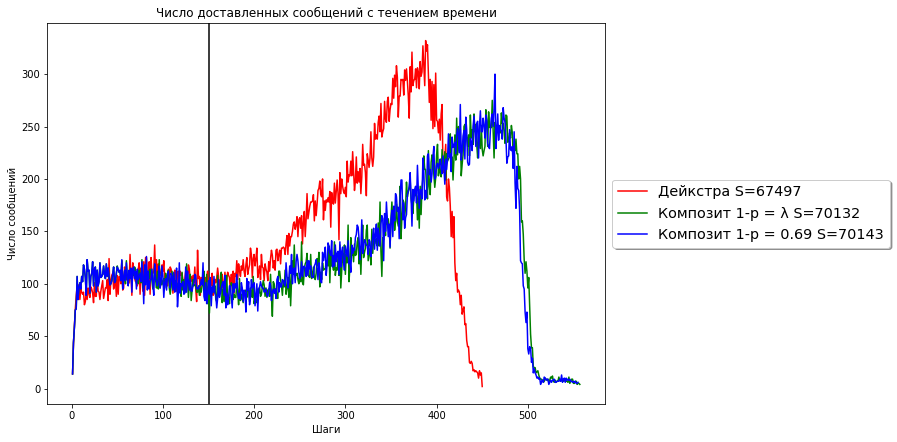

In [3]:
log_tags = [
 {"tag":  "69eb9686-3cc2-44fc-99f0-4dfea09c7623", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "522c8b21-4f99-4c7c-8d82-2a9ccafc4370", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "fcddc734-363c-455c-a1b3-578168ca541a", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

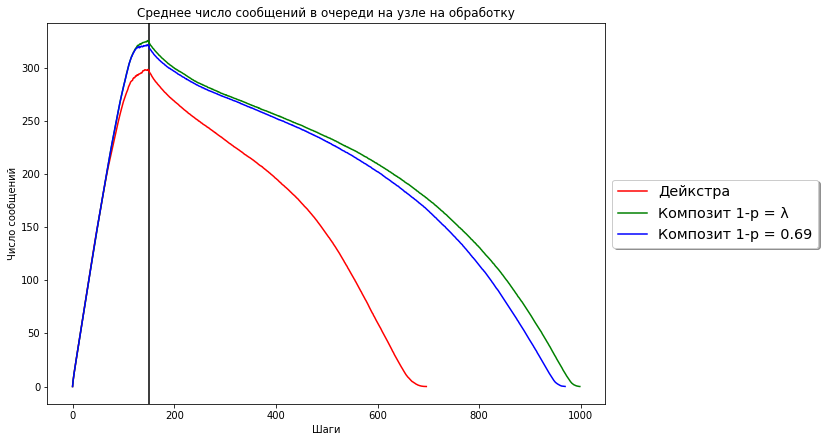

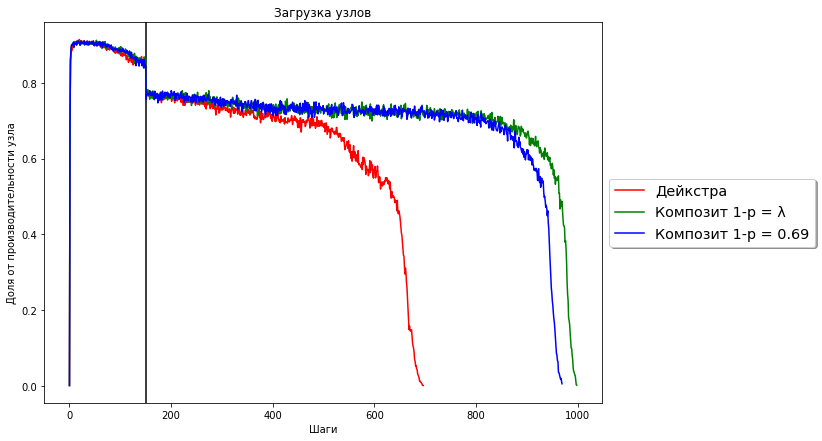

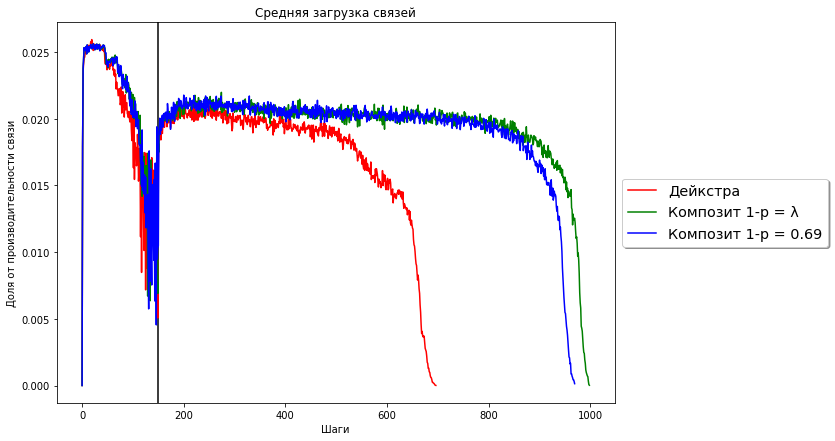

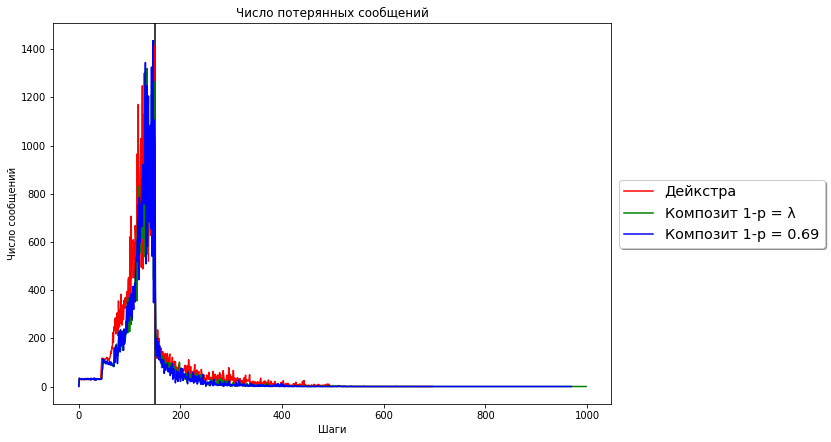

Доставлено 84960 Потеряно 43.3604% -Дейкстра
Доставлено 97632 Потеряно 34.9124% -Композит 1-p = λ
Доставлено 97140 Потеряно 35.2404% -Композит 1-p = 0.69


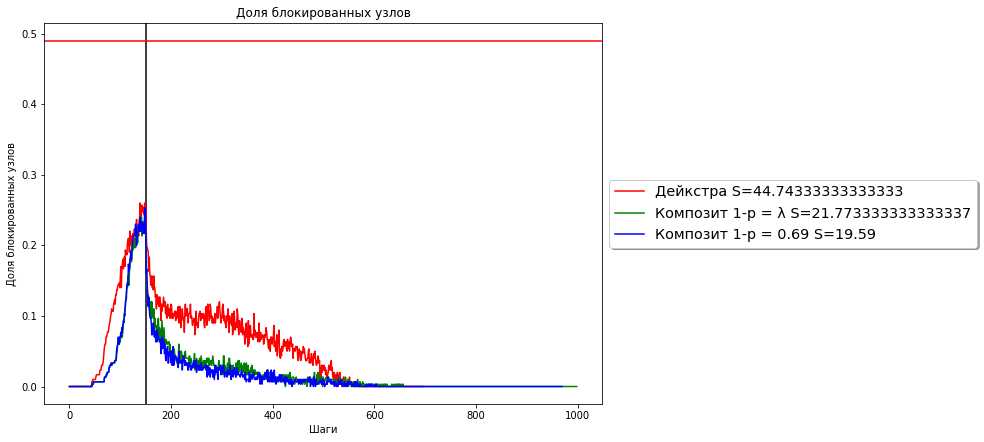

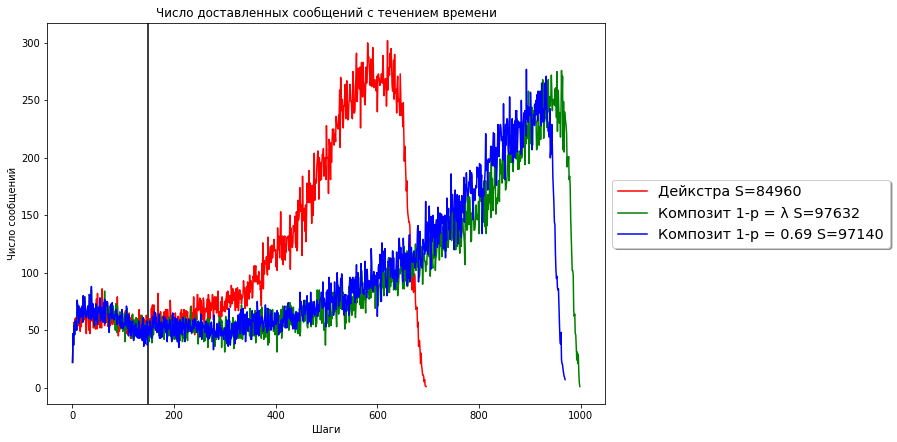

In [4]:
log_tags = [
 {"tag":  "c2519a5c-e26d-4549-981b-e4c053b99cbc", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "eec16819-54d7-42b0-a9fe-7dba769cc4f4", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "05d556bc-6981-4c4c-9d20-92fdc26b5204", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

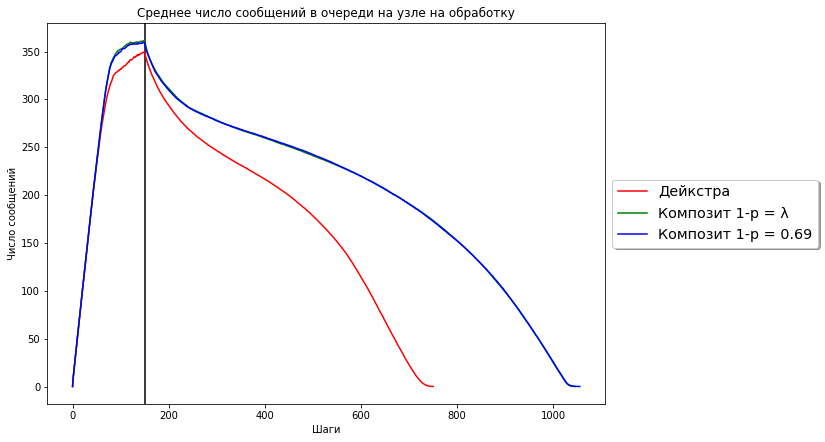

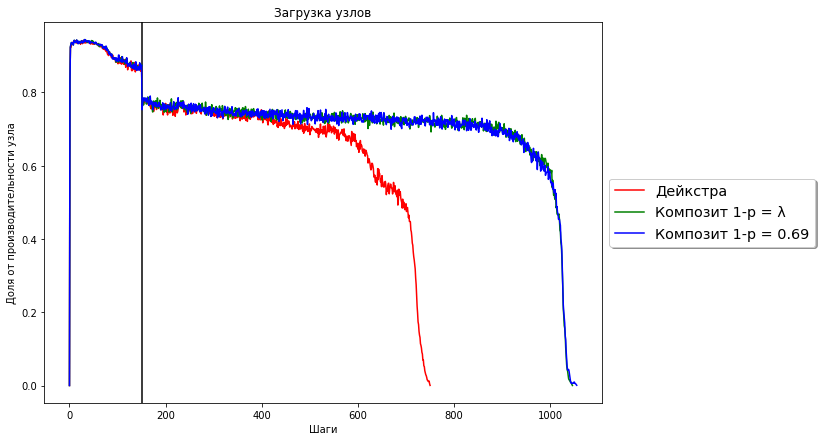

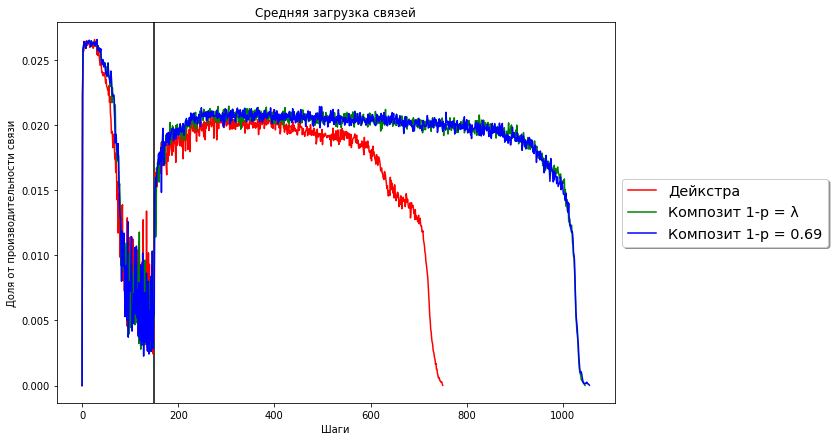

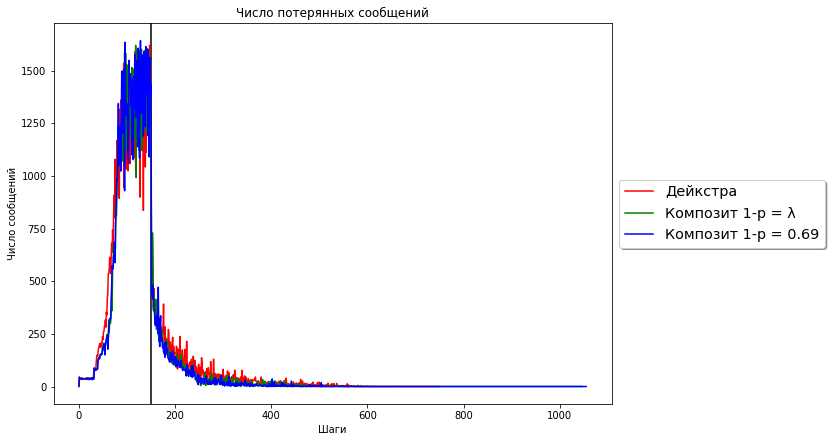

Доставлено 83349 Потеряно 62.9562% -Дейкстра
Доставлено 94192 Потеряно 58.1371% -Композит 1-p = λ
Доставлено 94694 Потеряно 57.9140% -Композит 1-p = 0.69


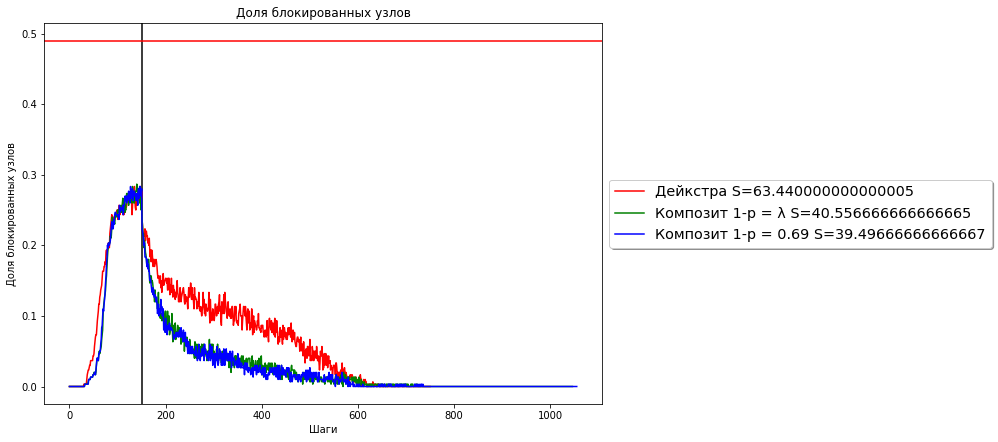

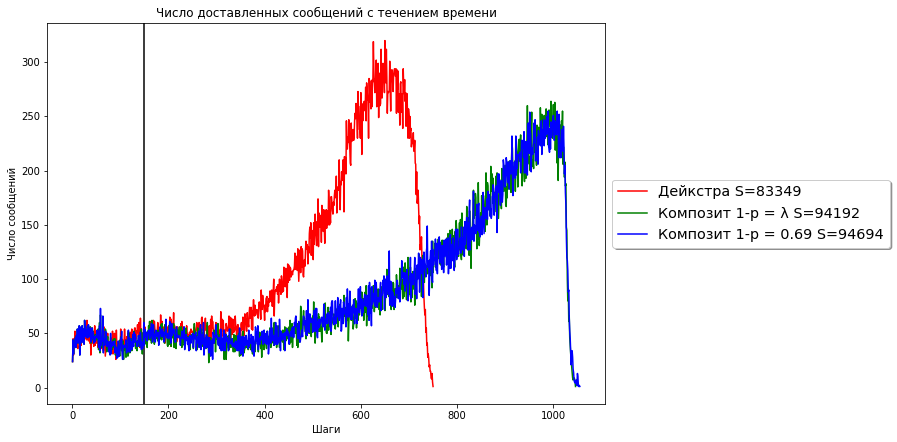

In [5]:
log_tags = [
 {"tag":  "928096ad-2165-410d-b84f-17bf96f7456d", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "a17638fb-15c2-4832-a4e0-9aa853129fe6", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "a22bf8b6-c1c9-4b1b-95a1-1753db97496d", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 42979 Потеряно 4.4932% -Дейкстра
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = λ
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = 0.69


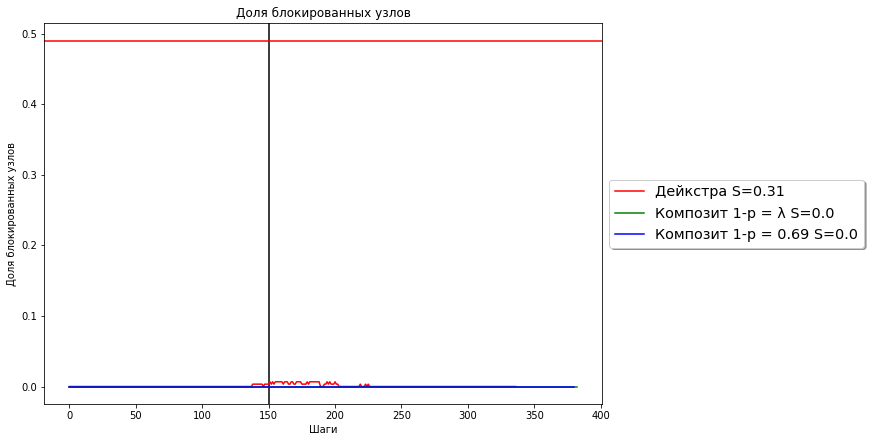

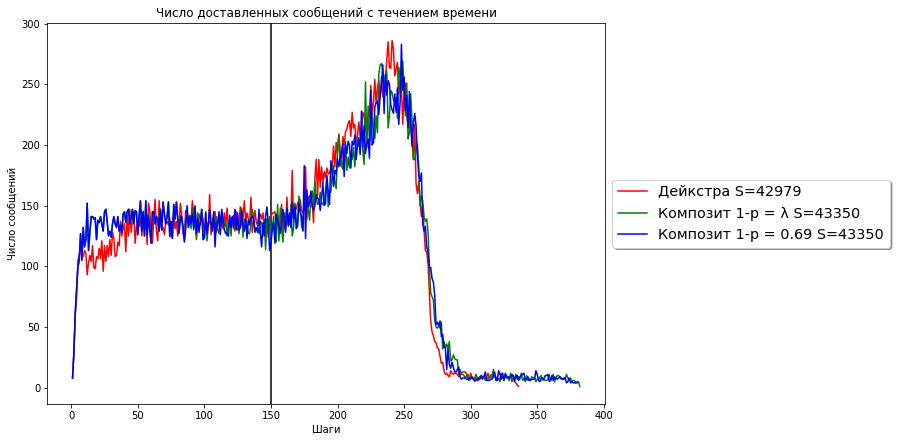

Доставлено 80396 Потеряно 23.4331% -Дейкстра
Доставлено 90817 Потеряно 13.5084% -Композит 1-p = λ
Доставлено 90971 Потеряно 13.3618% -Композит 1-p = 0.69


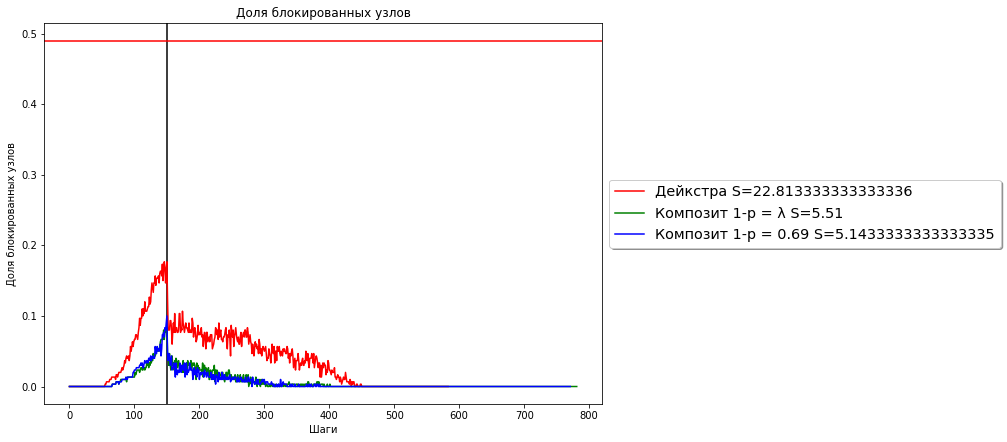

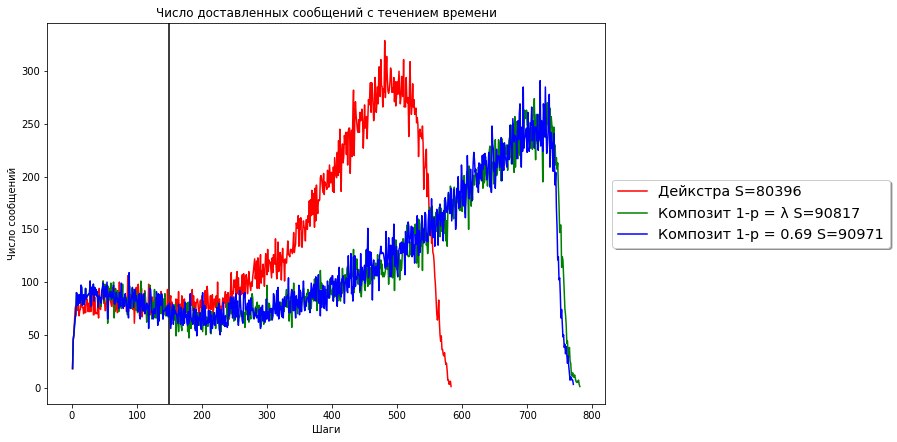

Доставлено 85122 Потеряно 36.9471% -Дейкстра
Доставлено 97982 Потеряно 27.4213% -Композит 1-p = λ
Доставлено 98132 Потеряно 27.3102% -Композит 1-p = 0.69


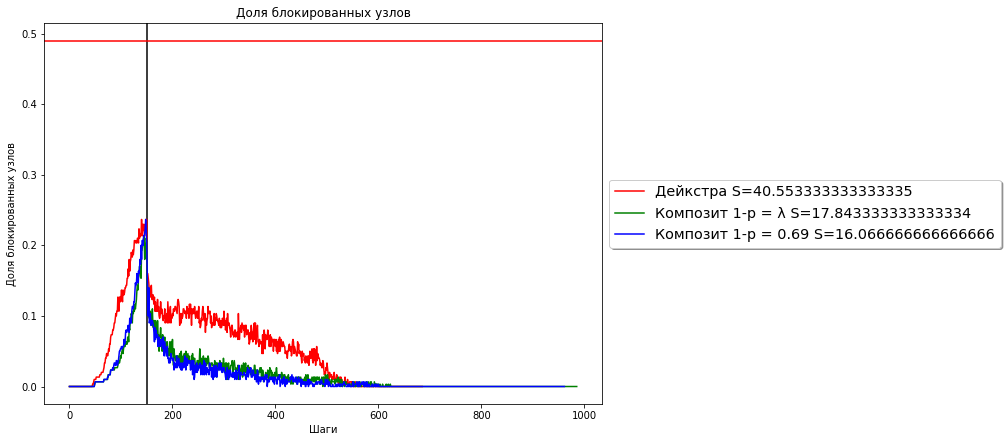

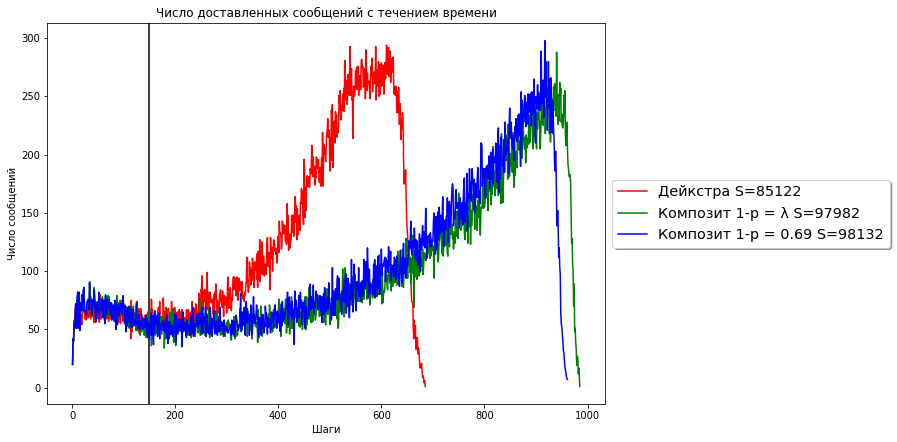

Доставлено 84098 Потеряно 56.8730% -Дейкстра
Доставлено 95769 Потеряно 50.8879% -Композит 1-p = λ
Доставлено 96444 Потеряно 50.5418% -Композит 1-p = 0.69


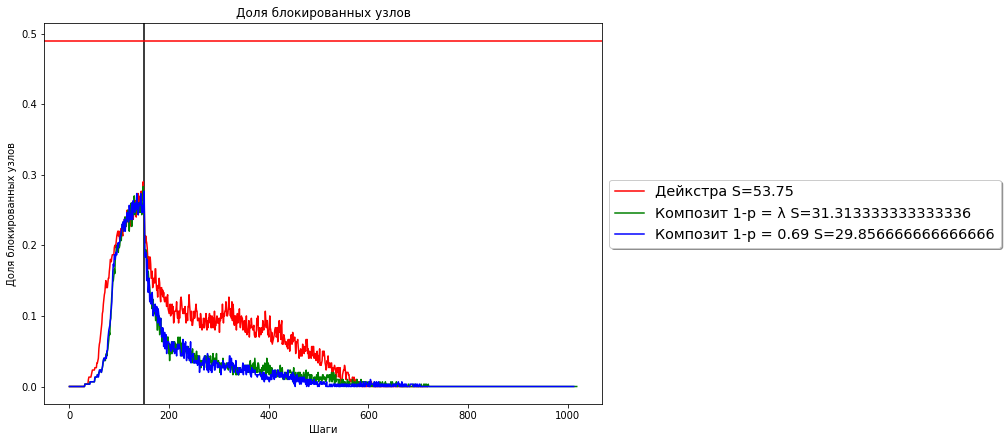

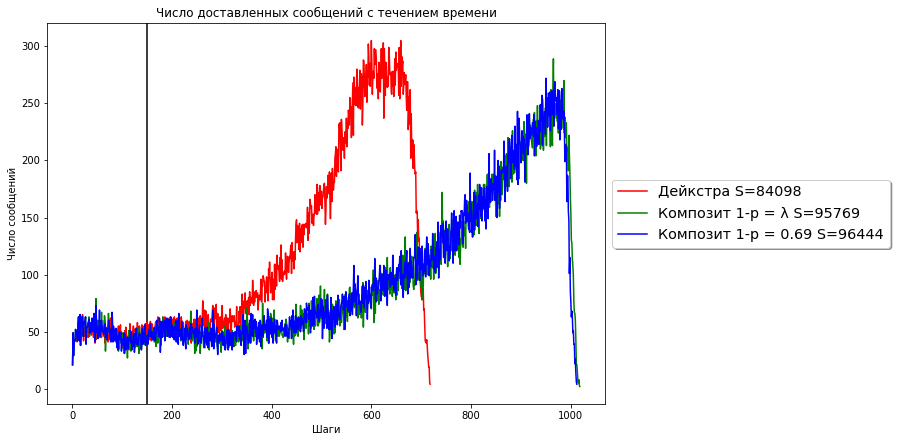

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "186d0a9a-92fd-4096-9175-e5736c2c2461", "label": "Дейкстра", "color": "red"},
 {"tag":  "04d6122b-2057-4ab9-b6ae-6935e707e04b", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "5dda0d7f-f6e9-4385-89e9-ef1b7b06d8e5", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "401abd36-464e-4b7a-a524-9ce92e23f952", "label": "Дейкстра", "color": "red"},
 {"tag":  "78be580a-8c15-487b-b44d-165d6ef3e16a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "07ebd657-f54b-4b0e-b582-ec92cb1dde37", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "cd9d9e6f-02a3-4c50-84e3-39a67b07e324", "label": "Дейкстра", "color": "red"},
 {"tag":  "5b0c1ec1-52fd-44d5-aee6-3dcd64c879aa", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "203021e4-ac69-4fc2-9f0f-473c4cc4615e", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "64ecaaa7-3073-4d3b-b9fa-40adef021cb4", "label": "Дейкстра", "color": "red"},
 {"tag":  "f8645859-31dc-4c93-b5fb-cded916d1db4", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "a2146cdb-6126-467c-84eb-de1da82308d9", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

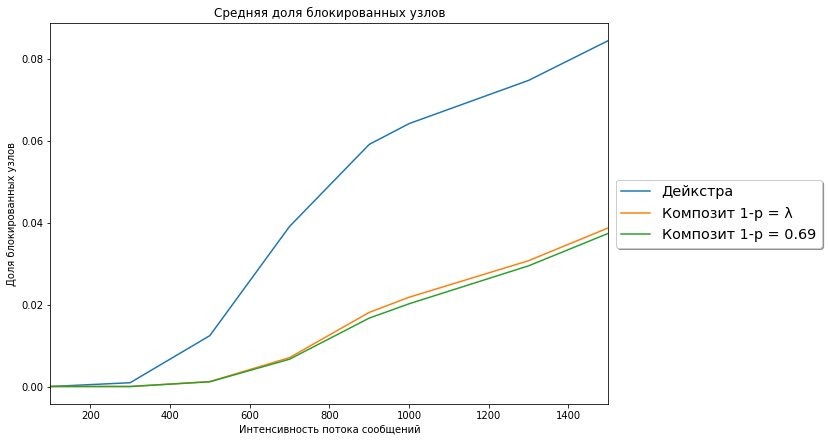

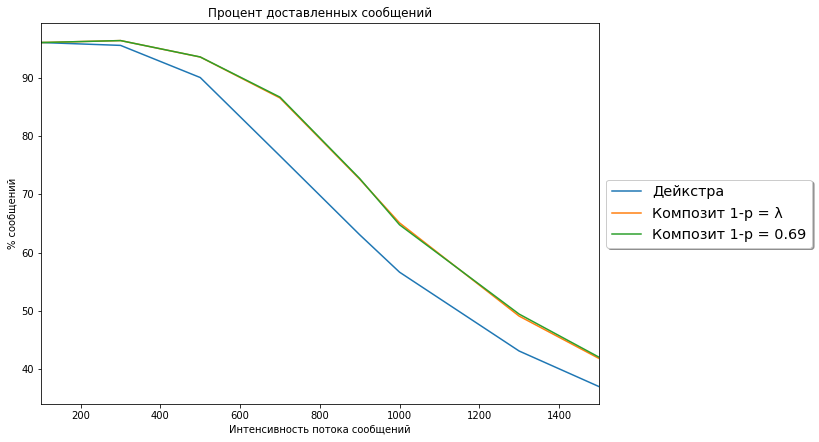

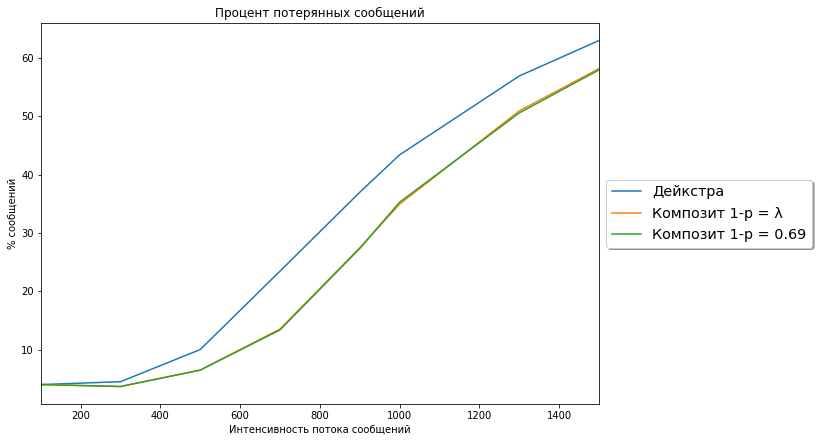

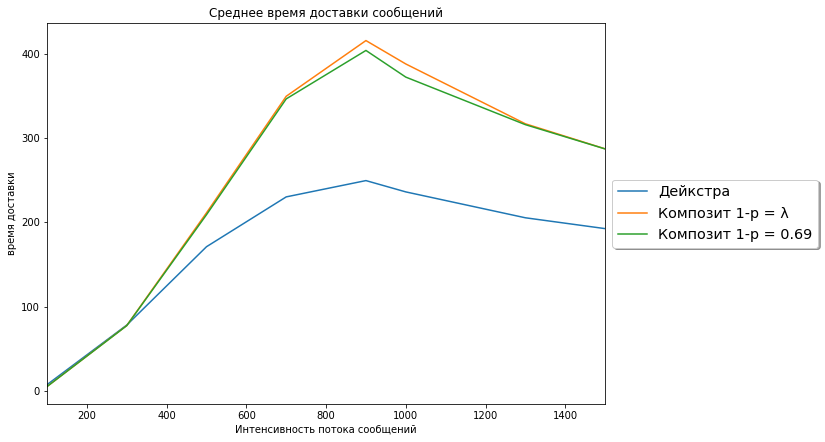

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.041867
Композит 1-p = λ       0.014701
Композит 1-p = 0.69    0.013948

Дейкстра               30.258499
Композит 1-p = λ       24.879287
Композит 1-p = 0.69    24.815074

Дейкстра               171.270438
Композит 1-p = λ       256.419003
Композит 1-p = 0.69    252.178514
